# pyBumpHunter Example

Simple notebook for testing the pyBumpHunter.py package.

We will use histograms ranging between 0 and 20 with 60 even bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyBumpHunter as BH
from datetime import datetime  ## Used to compute the execution time
import uproot as upr  ## Used to read data from a root file

## Load input file

The data (in a ROOT file format) consists of three histograms: a steeply falling 'background' distribution in a [0,20] x-axis range, a 'signal' gaussian shape centered on a value of 5.5, and a 'data' distribution sampled from background and signal distributions, with a signal fraction of 0.15%.


In [2]:
# Open the file
File = upr.open('../data/data.root')
File.items()

# Background
bkg = File['bkg'].arrays(library='np')['bkg']

# Data
data = File['data'].arrays(library='np')['data']

# Signal
sig = File['sig'].arrays(library='np')['sig']

# Position of the bump in the data
Lth = 5.5

# Range for the histogram
rang = [0,20]

In [3]:
bkg.shape

(99996,)

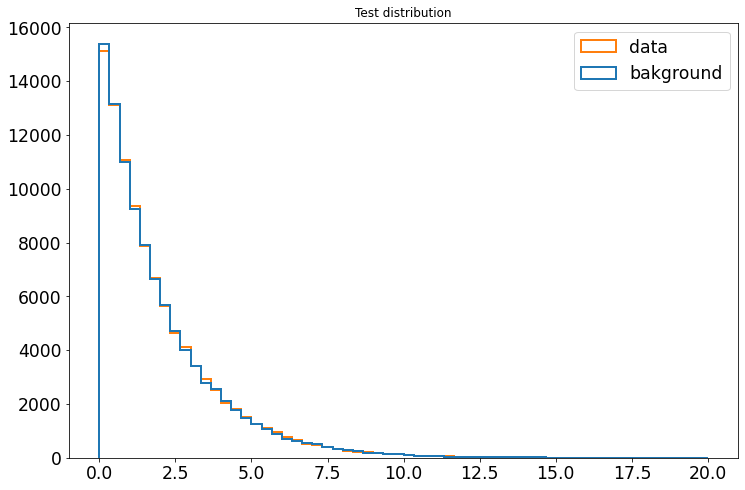

In [4]:
# Plot the 2 distributions (data and background)
F = plt.figure(figsize=(12,8))
plt.title("Test distribution")
plt.hist(
    (bkg, data),
    bins=60,
    histtype="step",
    range=rang,
    label=("bakground", "data"),
    linewidth=2,
)
plt.legend(fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.show()

## Create a DataHandler class instance

The DataHandler class take care of managing histograms.

It can handle histograms with 1 or 2 dimension for multiple channels.

In [5]:
dh = BH.DataHandler(ndim=1, nchan=1) # 1D histograms and 1 single channel
dh.set_ref(bkg, bins=60, rang=rang) # Build reference background histogram
dh.set_data(data) # Build data histogram (re-use binning and range previously set)
dh.set_sig(sig, signal_exp=150) # Build signal histogram

## Create a BumpHunter1D class instance.

The BumpHunter1D class provides all the methods required to "bump hunt" in ease.

All the parameters and results are also stored in this object.

In [6]:
hunter = BH.BumpHunter1D(
    width_min=2,
    width_max=6,
    width_step=1,
    scan_step=1,
    npe=10000,
    nworker=1,
    seed=666,
)

## Call the BumpScan Method

The function will scan the data distribution using variable-width window sizes (between width_min and width_max) and calculate the p-value of data with respect to the background for each window. The minimum p-value obtained from all windows is the local p-value.

To cope with the look-elsewhere effect a global p-value is calculated using a two-step procedure:
- the distribution of possible p-values is determined from background-only pseudo-experiments (npe parameter)
- the p-value found in data is compared to the background-only p-value distribution to calculate the global p-value

In [7]:
print('####bump_scan call####')
begin = datetime.now()
hunter.bump_scan(dh)
end = datetime.now()
print(f'time={end - begin}')

####bump_scan call####
Generating 10000 background-only histograms
5 values of width will be tested
SCAN CH0
####CH0
Global p-value : 0.01770  (177 / 10000)
Significance = 2.10375
time=0:00:17.458981


## Print results of BH scan

Print information on more significant window ("bump"): location, width, excess over background events, global p-value and global significance.

In [8]:
print(hunter.bump_info(dh))
print(f'   mean (true) = {Lth}')

####BUMP SCAN SUMMARY####
Channel 0 :
    Bump edges : [5.33, 6.67] (loc=16, width=4)
    Bump mean | width : 6 | 1.33
    Number of signal events : 208
    Local p-value | test statistic : 0.00017341 | 8.66
    Local significance : 3.5776
    global p-value : 0.0177
    global significance : 2.1038
    No fit for this channel

   mean (true) = 5.5


## Tomography plot

This figure shows the p-value in each of the windows used to scan the data distribution.

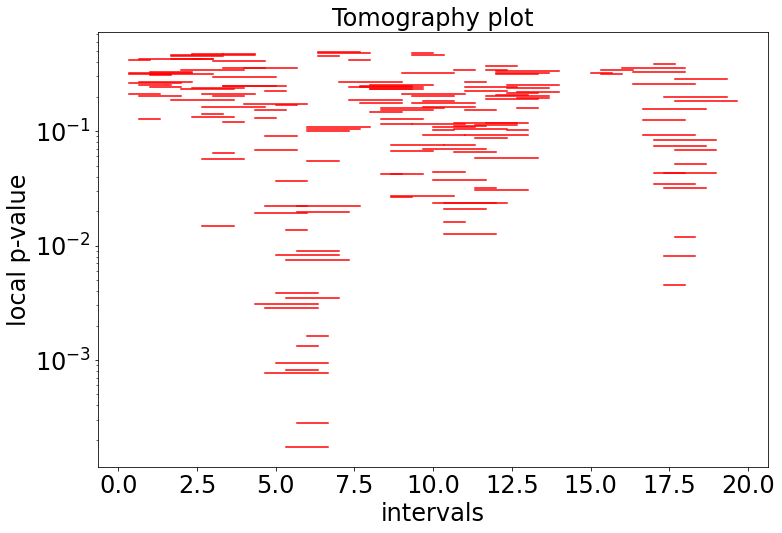

In [9]:
F = plt.figure(figsize=(12, 8))
plt.title("Tomography plot", size=24)
hunter.plot_tomography(dh)
plt.xlabel("intervals", size=24)
plt.ylabel("local p-value", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

## Show most significant window

Window with the lowest p-value obtained from the data scans.

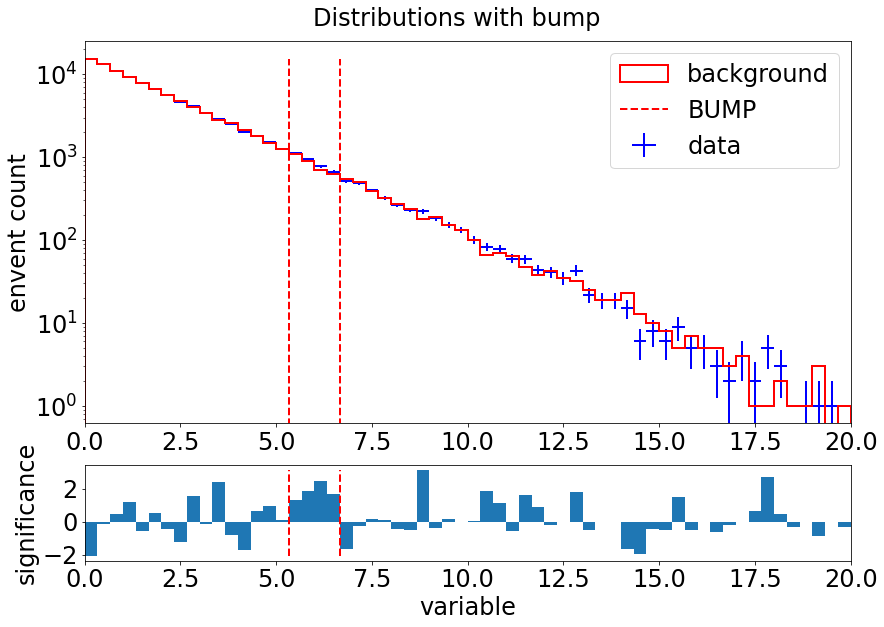

In [10]:
F = plt.figure(figsize=(12, 8))
plt.suptitle("Distributions with bump", size=24)
pl = hunter.plot_bump(dh, fontsize=24)
pl[0].legend(fontsize=24)
pl[0].axes.set_ylabel("envent count", size=24)
pl[1].axes.set_xlabel("variable", size=24)
pl[1].axes.set_ylabel("significance", size=24)
plt.show()

## Global p-value

This figure shows the test statistics (log(p-value)) obtained from background-only toys and the p-value obtained from data. The global p-value is equal to the fraction of background-only experiments whch have a higher test statistics than for the data (i.e this is the p-value of p-values).

If the global p-value becomes too small, an automatic fit of the test statistic distribution is performed.

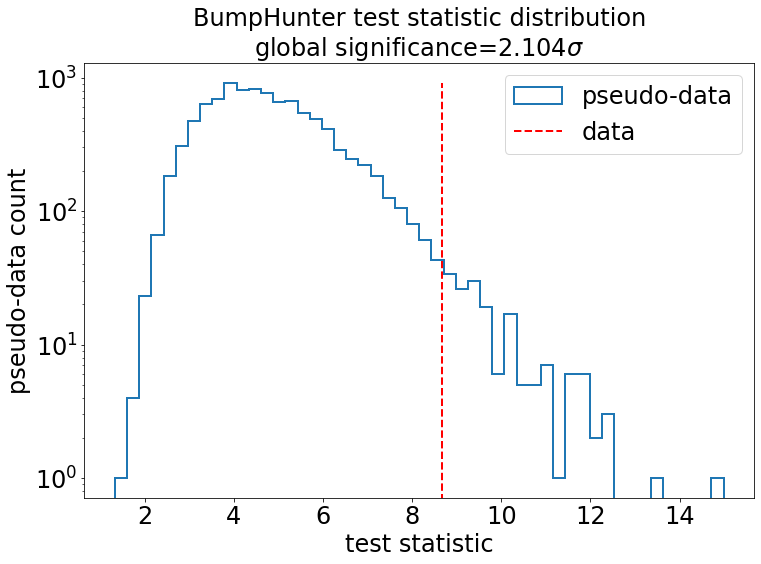

In [11]:
F = plt.figure(figsize=(12, 8))
plt.title(f"BumpHunter test statistic distribution\nglobal significance={hunter.significance[0]:.3f}$\sigma$", size=24)
hunter.plot_stat()
plt.legend(fontsize=24)
plt.xlabel("test statistic", size=24)
plt.ylabel("pseudo-data count", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

## Signal injection

Inject signal in data until a 5 sigma excess is found. 

In [12]:
# We have to set additionnal parameters specific to the signal injection.
# All the parameters defined previously are kept.
hunter.sigma_limit = 5
hunter.str_min = -1 # if str_scale='log', the real starting value is 10**str_min
hunter.str_scale = 'log'
hunter.npe_inject = 1000

print('####singal_inject call####')
begin = datetime.now()
hunter.signal_inject(dh, do_pseudo=False) # We don't need to re-do the bkg-only pseudo-data
end = datetime.now()
print(f'time={end - begin}')
print('')

####singal_inject call####
5 values of width will be tested
STARTING INJECTION
   STEP 1 : signal strength = 0.1
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.47930  (4793 / 10000)   0.74820  (7482)   0.22830  (2283)
Significance = 0.051911 (-0.66884  0.74446)

   STEP 2 : signal strength = 0.2
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.49970  (4997 / 10000)   0.72380  (7238)   0.22290  (2229)
Significance = 0.00075199 (-0.59417  0.76244)

   STEP 3 : signal strength = 0.30000000000000004
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.44480  (4448 / 10000)   0.70930  (7093)   0.21160  (2116)
Significance = 0.13881 (-0.55134  0.80088)

   STEP 4 : signal strength = 0.4
Generating 1000 background+signal histograms
BACKGROUND+SIGNAL SCAN CH0
####CH0
Global p-value : 0.42520  (4252 / 10000)   0.68380  (6838)   0.19920  (1992)
Signi

## Plot injection results

Show the evolution of the global significance with the signal strength.

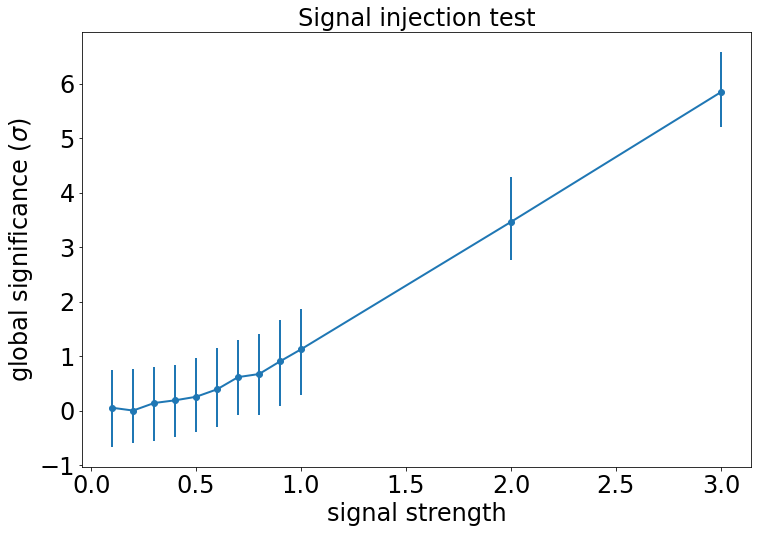

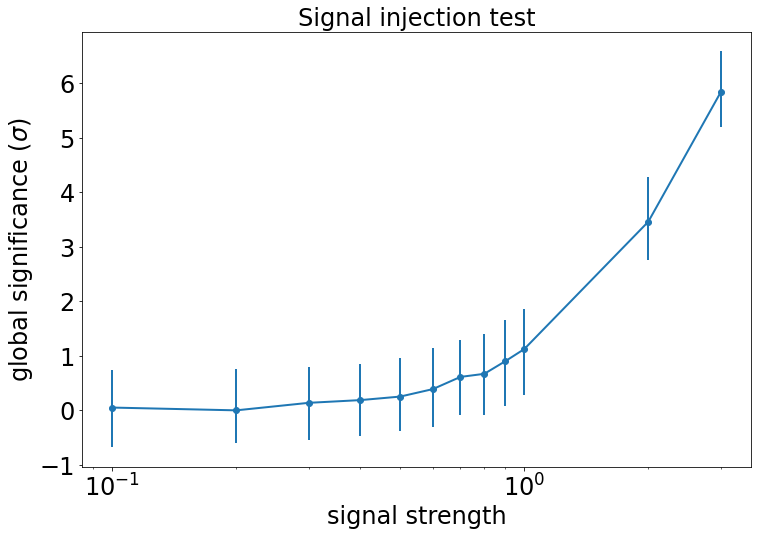

In [13]:
F = plt.figure(figsize=(12,8))
plt.title("Signal injection test", size=24)
hunter.plot_inject()
plt.xlabel("signal strength", size=24)
plt.ylabel("global significance ($\sigma$)", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()
F = plt.figure(figsize=(12,8))
plt.title("Signal injection test", size=24)
hunter.plot_inject(log=True)
plt.xlabel("signal strength", size=24)
plt.ylabel("global significance ($\sigma$)", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

## Test statistic distributions

Show the test statistic distribution of the bkg-only and bkg+sig cases.

Note the fit of the bkg-only distribution.

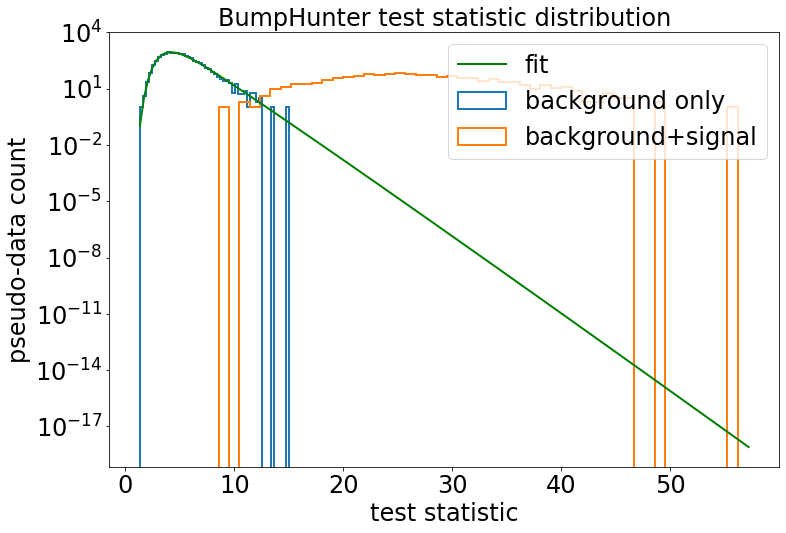

In [14]:
F = plt.figure(figsize=(12, 8))
plt.title("BumpHunter test statistic distribution", size=24)
hunter.plot_stat()
plt.legend(fontsize=24)
plt.xlabel("test statistic", size=24)
plt.ylabel("pseudo-data count", size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()